In [1]:
# load packages
import pandas as pd
import numpy as np
import seaborn as sns 
import pandas.testing
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os 
%matplotlib inline

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.getcwd()
df = pd.read_csv("HR-Employee-Attrition.csv")
# Remove EmployeeCount, StandardHours, Over18 since there is no variation
df = df.drop(df[["EmployeeCount", "StandardHours", "Over18", "EmployeeNumber"]], axis = 1)
df["Attrition"] = np.where(df["Attrition"] == "Yes", 1, 0)
data_orig = df

# Modeling Part

In [3]:
df = data_orig

In [4]:
categorical = df.select_dtypes(include=["object"])
numeric = df.select_dtypes(include=["int"])

### Import all necessary packages

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, recall_score, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from numpy import arange
from numpy import argmax

In [6]:
df = data_orig

In [7]:
df.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

* ## Variance Inflation Factor

In [8]:
#Imports
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

categorical = df.select_dtypes(include=["object"])

xx = data_orig.drop(["Attrition"],1)
data = xx.select_dtypes(include=["int"])
# data = pd.get_dummies(xx, columns = categorical.columns, drop_first = True)
data = sm.add_constant(data)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, i)
                          for i in range(len(data.columns))]
  
print(vif_data)

                     feature         VIF
0                      const  202.093542
1                        Age    2.044890
2                  DailyRate    1.018198
3           DistanceFromHome    1.015515
4                  Education    1.059352
5    EnvironmentSatisfaction    1.010099
6                 HourlyRate    1.018318
7             JobInvolvement    1.016316
8                   JobLevel   11.205067
9            JobSatisfaction    1.014511
10             MonthlyIncome   10.800070
11               MonthlyRate    1.012282
12        NumCompaniesWorked    1.257737
13         PercentSalaryHike    2.516385
14         PerformanceRating    2.513734
15  RelationshipSatisfaction    1.015771
16          StockOptionLevel    1.017682
17         TotalWorkingYears    4.767796
18     TrainingTimesLastYear    1.009917
19           WorkLifeBalance    1.014884
20            YearsAtCompany    4.587391
21        YearsInCurrentRole    2.718604
22   YearsSinceLastPromotion    1.674278
23      YearsWit

As expected, JobLevel and MonthlyIncome have a high variance inflation factor because they "explain" the same variance within this dataset. We would need to discard one of these variables before moving on to model building or risk building a model with high multicolinearity. I will remove JobLevel from the dataset. We usually remove feature if their vif score is higher than 10 or 5. However, we aren’t necessarily removing every feature with a vif score above 10, if it is a feature we care about we may want to remove other features instead to help get the vif score below 10 for that feature. Therefore, I will keep MonthlyIncome feature to use in the model.

## Define Some Functions

In [9]:
def model_built(selected_model):    
    model = selected_model.fit(X_train, y_train)
    return model

In [10]:
def model_metrics(selected_model):
    
    model = selected_model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    accuracy = accuracy_score(y_test, y_pred)
    
    print("Accuracy Score", "\n", accuracy, "\n")
    
    print("f1 score", "\n", f1_score(y_test, y_pred), "\n")
    
    print("ROC auc", "\n", roc_auc_score(y_test, y_pred), "\n")
    
    print("Classification Report", "\n", classification_report(y_pred, y_test), "\n")
    
    print("Confusion Matrix")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, square=True, annot=True, annot_kws={"size": 16}, fmt='d', cbar=False, cmap = 'Blues_r')
    plt.xlabel('Predicted', fontsize = 14)
    plt.ylabel('Actual', fontsize = 14)
    plt.show()
    

In [11]:
def confusion_matrix_default(builted_model):
    
    y_pred = builted_model.predict(X_test)
    print("Confusion Matrix for Default Model", "\n")
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, square=True, annot=True, annot_kws={"size": 16}, fmt='d', cbar=False, cmap = 'Blues_r')
    plt.xlabel('Predicted', fontsize = 14)
    plt.ylabel('Actual', fontsize = 14)
    plt.show()
    
def confusion_matrix_with_new_treshold(builted_model):
    y_pred_50 = builted_model.predict(X_test)
    y_proba = builted_model.predict_proba(X_test)[:,1]
    
    threshold = []
    accuracy = []
    roc_auc = []
    f1score = []
    for i in arange(0,1,0.01):
        predicted = (y_proba >= i).astype('int')
        threshold.append(i)
        accuracy.append(accuracy_score(y_test, predicted))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        f1score.append(f1_score(y_test, predicted))
    pd_df = pd.DataFrame({"Threshold": threshold,
                          'Accuracy': accuracy,
                          'Roc AUC': roc_auc,
                          'f1_score': f1score
                         }).sort_values("f1_score", ascending = False)
    
    new_treshold = pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0]
    y_pred_new = (y_proba >= new_treshold).astype('int')
    

    print("Confusion Matrix for Optimum Treshold", "\n")
    conf_matrix = confusion_matrix(y_test, y_pred_new)
    sns.heatmap(conf_matrix, square=True, annot=True, annot_kws={"size": 16}, fmt='d', cbar=False, cmap = 'Blues_r')
    plt.xlabel('Predicted', fontsize = 14)
    plt.ylabel('Actual', fontsize = 14)
    plt.show()

In [12]:
def new_treshold(builted_model):
    from sklearn.metrics import f1_score
    y_pred_50 = builted_model.predict(X_test)
    y_proba = builted_model.predict_proba(X_test)[:,1]
    
    threshold = []
    accuracy = []
    roc_auc = []
    f1score = []
    for i in arange(0,1,0.01):
        predicted = (y_proba >= i).astype('int')
        threshold.append(i)
        accuracy.append(accuracy_score(y_test, predicted))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        f1score.append(f1_score(y_test, predicted))
    pd_df = pd.DataFrame({"Threshold": threshold,
                          'Accuracy': accuracy,
                          'Roc AUC': roc_auc,
                          'f1_score': f1score
                         }).sort_values("f1_score", ascending = False)
    
    new_treshold = round(pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0],4)
    return new_treshold

def f1_score_for_new_treshold(builted_model):
    from sklearn.metrics import f1_score
    y_pred_50 = builted_model.predict(X_test)
    y_proba = builted_model.predict_proba(X_test)[:,1]
    
    threshold = []
    accuracy = []
    roc_auc = []
    f1score = []
    for i in arange(0,1,0.01):
        predicted = (y_proba >= i).astype('int')
        threshold.append(i)
        accuracy.append(accuracy_score(y_test, predicted))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        f1score.append(f1_score(y_test, predicted))
    pd_df = pd.DataFrame({"Threshold": threshold,
                          'Accuracy': accuracy,
                          'Roc AUC': roc_auc,
                          'f1_score': f1score
                         }).sort_values("f1_score", ascending = False)
    
    f1_score = round(pd_df["f1_score"].max(),4)
    return f1_score 
 
 

In [13]:
def classification_report_default(builted_model):
    from sklearn.metrics import f1_score
    y_pred = builted_model.predict(X_test)
    print("Classification Report", "\n", classification_report(y_pred, y_test), "\n")
    

def classification_report_with_new_treshold(builted_model):
    from sklearn.metrics import f1_score
    threshold = []
    accuracy = []
    roc_auc = []
    f1score = []
    y_proba = builted_model.predict_proba(X_test)[:,1]
    for i in arange(0,1,0.01):
        predicted = (y_proba >= i).astype('int')
        threshold.append(i)
        accuracy.append(accuracy_score(y_test, predicted))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        f1score.append(f1_score(y_test, predicted))
    pd_df = pd.DataFrame({"Threshold": threshold,
                          'Accuracy': accuracy,
                          'ROC AUC': roc_auc,
                          'f1_score': f1score
                         }).sort_values("f1_score", ascending = False)
    
    treshold_new =  pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0]
    predicted_new = (y_proba >= treshold_new).astype('int')
    print("New Treshold", treshold_new)
    print("Classification Report", "\n", classification_report(predicted_new, y_test), "\n")
    

In [14]:
def roc_curve(builted_model):
    from sklearn.metrics import roc_curve
    y_proba = builted_model.predict_proba(X_test)[:, 1]
    
    # plot the roc curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

    plt.plot(fpr, tpr, label="Builted Model")

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend()
    # show the plot
    plt.show()
    
def roc_curve_with_new_threshold(builted_model, model_name = ""):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import f1_score
    
    y_pred_50 = builted_model.predict(X_test)
    y_proba = builted_model.predict_proba(X_test)[:,1]
    
    threshold = []
    accuracy = []
    roc_auc = []
    f1score = []
    for i in arange(0,1,0.01):
        predicted = (y_proba >= i).astype('int')
        threshold.append(i)
        accuracy.append(accuracy_score(y_test, predicted))
        roc_auc.append(roc_auc_score(y_test, y_proba))
        f1score.append(f1_score(y_test, predicted))
    pd_df = pd.DataFrame({"Threshold": threshold,
                          'Accuracy': accuracy,
                          'ROC AUC': roc_auc,
                          'f1_score': f1score,
                         }).sort_values("f1_score", ascending = False)
    
    # print(pd_df.head(10))

    new_threshold = pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0]
    f1_score = pd_df["f1_score"].max()
    y_pred_new = (y_proba >= new_threshold).astype('int')
    
    # plot roc curves
    plt.figure(figsize = (8,5))
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')

    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=model_name + " (ROC Auc = %.2f)"%(roc_auc))

    ix = argmax(f1score)
    plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold = %.2f, f1_score = %.2f ' % (new_threshold, f1_score))

    # axis labels
    plt.xlabel('False Positive Rate', fontsize = 14)
    plt.ylabel('True Positive Rate', fontsize = 14)
    plt.title("ROC Curve", fontsize = 18)
    plt.legend()
    # show the plot
    plt.show()

In [15]:
def precision_recall_curve_with_new_threshold(builted_model, model_name =""):
    from sklearn.metrics import precision_recall_curve

    y_pred_50 = builted_model.predict(X_test)
    y_proba = builted_model.predict_proba(X_test)[:,1]
    new_threshold = pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0]
    y_pred_new = (y_proba >= new_threshold).astype('int')

    # Plot the Precision Recall curve
    plt.figure(figsize = (8,5))
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')

    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, marker='.', label=model_name)

    # locate the index of the largest f score
    fscore = (2 * precision * recall) / (precision + recall)
    ix = argmax(fscore)
    # put the best treshold on the curve
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best Threshold = %.2f, f1_score = %.2f ' % ( new_threshold, fscore[ix]))

    # axis labels
    plt.xlabel('Recall', fontsize = 14)
    plt.ylabel('Precision', fontsize = 14)
    plt.title("Precision Recall Curve", fontsize = 18)
    plt.legend()
    plt.show()

## Model Pre-Process

In [16]:
df = data_orig
df = df.drop(["JobLevel"], 1)
categorical = df.select_dtypes(include=["object"])
numeric = df.select_dtypes(include=["int"])
# Create dummy variables
selected_data = pd.get_dummies(df, columns = categorical.columns, drop_first = True)
y = selected_data["Attrition"]
X = selected_data.drop(["Attrition"],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.45, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.45,  stratify=y)

X_train, y_train = SMOTE(random_state = 0).fit_resample(X_train, y_train)
scaler = StandardScaler()  
# Fitting only on training data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression

In [17]:
#### Select classificantion model
model_name = "Logistic Regression"
lr1 = model_built(LogisticRegression())

print(model_name, "Default Model")
print("=============================================================")
classification_report_default(lr1)

print("Grid Search Model")
print("=============================================================")
# Set up parameters
param_grid = {'penalty': ['l1', 'l2', None],
              'solver' : ['liblinear', 'lbfgs', None],
              'C':[0.0001,0.001,0.01,0.1,1,5,10,25, None]}

grid_search = GridSearchCV(estimator = lr1, param_grid = param_grid, cv = 5, scoring = "f1")
lr2 = model_built(grid_search)
classification_report_default(lr2)

print("Change Treshold")
print("=============================================================")
classification_report_with_new_treshold(lr2)

Logistic Regression Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       571
           1       0.44      0.51      0.47        91

    accuracy                           0.84       662
   macro avg       0.68      0.70      0.69       662
weighted avg       0.85      0.84      0.85       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       560
           1       0.50      0.51      0.50       102

    accuracy                           0.84       662
   macro avg       0.70      0.71      0.71       662
weighted avg       0.85      0.84      0.85       662
 

Change Treshold
New Treshold 0.51
Classification Report 
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       573
           1       0.47      0.55      0.51        89

    accuracy        

In [18]:
lr2.best_params_

{'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}

# Random Forest Model

In [19]:
# Select classificantion model
model_name = "Random Forest"
rf1 = model_built(RandomForestClassifier())

print(model_name, "Default Model")
print("=============================================================")
classification_report_default(rf1)


print("Grid Search Model")
print("=============================================================")
# Set up parameters
param_grid = {
    'min_samples_leaf': [5, 10, None],
    'criterion': ['gini', 'entropy', None], 
    'max_features' : ['sqrt', 'log2',None],
    'n_estimators': [100, 200, 500, 800, 1000, None]
}

grid_search = GridSearchCV(estimator = rf1, param_grid = param_grid, cv = 5, scoring = "f1")
rf2 = model_built(grid_search)
classification_report_default(rf2)

print("Change Grid Search Model Treshold")
print("=============================================================")
classification_report_with_new_treshold(rf2)

Random Forest Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.97      0.87      0.91       621
           1       0.21      0.54      0.30        41

    accuracy                           0.85       662
   macro avg       0.59      0.70      0.61       662
weighted avg       0.92      0.85      0.88       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.88      0.92       601
           1       0.32      0.56      0.41        61

    accuracy                           0.85       662
   macro avg       0.64      0.72      0.66       662
weighted avg       0.89      0.85      0.87       662
 

Change Grid Search Model Treshold
New Treshold 0.4
Classification Report 
               precision    recall  f1-score   support

           0       0.88      0.91      0.90       542
           1       0.52      0.46      0.49       120

    accur

In [20]:
rf2.best_params_

{'criterion': 'entropy',
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 1000}

# K-th Nearest Neighbour

In [21]:
# Select classificantion model
model_name = "KNN"

knn1 = model_built(KNeighborsClassifier())
print(model_name, "Default Model")
print("=============================================================")
classification_report_default(knn1)


print("Grid Search Model")
print("=============================================================")

#param_grid = {'n_neighbors': np.arange(1, 50)}
param_grid = dict(n_neighbors = [3,5,7,11,15,19,21,25,30,35,None], 
                  weights = ['uniform', 'distance', None],
                  metric = ["eucledian", "manhattan", None])


grid_search = GridSearchCV(estimator = knn1, param_grid = param_grid, cv = 10, scoring = 'f1')
knn2 = model_built(grid_search)
classification_report_default(knn2)

print("Change Treshold")
print("=============================================================")
classification_report_with_new_treshold(knn2)


KNN Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.85      0.86      0.86       547
           1       0.30      0.27      0.28       115

    accuracy                           0.76       662
   macro avg       0.57      0.57      0.57       662
weighted avg       0.75      0.76      0.76       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       531
           1       0.37      0.30      0.33       131

    accuracy                           0.76       662
   macro avg       0.60      0.59      0.59       662
weighted avg       0.74      0.76      0.75       662
 

Change Treshold
New Treshold 0.37
Classification Report 
               precision    recall  f1-score   support

           0       0.71      0.89      0.79       443
           1       0.55      0.26      0.36       219

    accuracy                        

In [22]:
knn2.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

# Support Vector Machine

In [23]:
# Select classificantion model
model_name = "SVM"

svm1 = model_built(SVC(probability = True))
print(model_name, "Default Model")
print("=============================================================")
classification_report_default(svm1)

print("Grid Search Model")
print("=============================================================")


param_grid = {'C': [0.01, 0.1, 1, 10, 50, None], 
              'gamma': [0.1, 0.15, 0.2, 0.5, 'auto'], 
              'kernel': ['poly', 'linear', None]}

grid_search = GridSearchCV(estimator = svm1, param_grid = param_grid, cv = 10, scoring = "f1")
svm2 = model_built(grid_search)
classification_report_default(svm2)

print("Change Grid Search Model Treshold")
print("=============================================================")
classification_report_with_new_treshold(svm2)

SVM Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.98      0.87      0.92       625
           1       0.23      0.65      0.34        37

    accuracy                           0.86       662
   macro avg       0.60      0.76      0.63       662
weighted avg       0.93      0.86      0.89       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       568
           1       0.37      0.41      0.39        94

    accuracy                           0.82       662
   macro avg       0.64      0.65      0.64       662
weighted avg       0.83      0.82      0.82       662
 

Change Grid Search Model Treshold
New Treshold 0.33
Classification Report 
               precision    recall  f1-score   support

           0       0.87      0.89      0.88       543
           1       0.44      0.39      0.41       119

    accuracy      

In [24]:
svm2.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'poly'}

# Gradient Boost

In [25]:
# Select classificantion model
model_name = "Gradient Boost"

gb1 = model_built(GradientBoostingClassifier())
print(model_name, "Default Model")
print("=============================================================")
classification_report_default(gb1)


print("Grid Search Model")
print("=============================================================")
param_grid ={
    'n_estimators': [100, 250, 500, 1000, None],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, None]
}


grid_search = GridSearchCV(estimator = gb1, param_grid = param_grid, cv = 10, scoring = 'f1')
gb2 = model_built(grid_search)
classification_report_default(gb2)


print("Change Grid Search Model Treshold")
print("=============================================================")
classification_report_with_new_treshold(gb2)



Gradient Boost Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.95      0.88      0.91       597
           1       0.33      0.54      0.41        65

    accuracy                           0.85       662
   macro avg       0.64      0.71      0.66       662
weighted avg       0.89      0.85      0.86       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.94      0.89      0.91       590
           1       0.36      0.53      0.43        72

    accuracy                           0.85       662
   macro avg       0.65      0.71      0.67       662
weighted avg       0.88      0.85      0.86       662
 

Change Grid Search Model Treshold
New Treshold 0.07
Classification Report 
               precision    recall  f1-score   support

           0       0.89      0.90      0.89       550
           1       0.48      0.45      0.46       112

    acc

In [26]:
gb2.best_params_

{'learning_rate': 0.2, 'n_estimators': 1000}

# Ada Boost

In [27]:
# Select classificantion model
model_name = "Ada Boost"

ada1 = model_built(AdaBoostClassifier())
print(model_name, "Default Model")
print("=============================================================")
classification_report_default(ada1)


print("Grid Search Model")
print("=============================================================")
param_grid ={
    'n_estimators': [150, 180, 200, None],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.3, None]
}

grid_search = GridSearchCV(estimator = ada1, param_grid = param_grid, cv = 10, scoring = 'f1')
ada2 = model_built(grid_search)
classification_report_default(ada2)

print("Change Grid Search Model Treshold")
print("=============================================================")
classification_report_with_new_treshold(ada2)



Ada Boost Default Model
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.88      0.89       567
           1       0.35      0.39      0.37        95

    accuracy                           0.81       662
   macro avg       0.62      0.63      0.63       662
weighted avg       0.82      0.81      0.81       662
 

Grid Search Model
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       559
           1       0.46      0.47      0.46       103

    accuracy                           0.83       662
   macro avg       0.68      0.68      0.68       662
weighted avg       0.83      0.83      0.83       662
 

Change Grid Search Model Treshold
New Treshold 0.5
Classification Report 
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       559
           1       0.46      0.47      0.46       103

    accuracy 

In [28]:
ada2.best_params_

{'learning_rate': 0.2, 'n_estimators': 180}

# Model Comparison

In [30]:
# Dictionary of f1 scores
d = {'Logistic Regression': [lr1, lr2, lr2], 
     'Random Forest': [rf1, rf2, rf2], 
     'KNN': [knn1, knn2, knn2], 
     'SVM': [svm1, svm2, svm2],
     'Gradient Boosting': [gb1, gb1, gb2],
     'ADA Boosting': [ada1, ada2, ada2]}

for i, v in d.items():
    v[0] = f1_score(y_test, v[0].predict(X_test),4)
    v[1] = f1_score(y_test, v[1].predict(X_test),4)
    v[2] = f1_score_for_new_treshold(v[2])

comparison_table = pd.DataFrame.from_dict(d, orient='index')
comparison_table.columns = ['default_model', 'grid_search_model', 'moved_threshold']
comparison_table["default_model"] = comparison_table["default_model"].round(4)
comparison_table["grid_search_model"] = comparison_table["grid_search_model"].round(4)
comparison_table

,default_model,grid_search_model,moved_threshold
Logistic Regression,0.4694,0.5024,0.5052
Random Forest,0.3014,0.4096,0.4889
KNN,0.2818,0.3305,0.3580
SVM,0.3380,0.3920,0.4107
Gradient Boosting,0.4118,0.4118,0.4608
ADA Boosting,0.3700,0.4615,0.4615


# Model Evaluation for Logistic Regression Classification

* ## Confusion Matrix Before and After Moving Treshold

Confusion Matrix for Default Model 



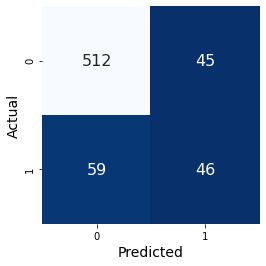



Confusion Matrix for Optimum Treshold 



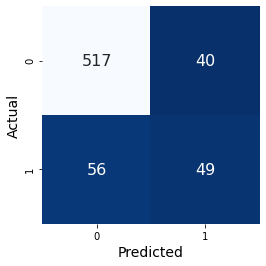

In [44]:
from sklearn.metrics import f1_score
confusion_matrix_default(lr1)
print("\n")
confusion_matrix_with_new_treshold(lr2)

* ## Optimum Threshold for Logistic Regression to get maximum f1 score

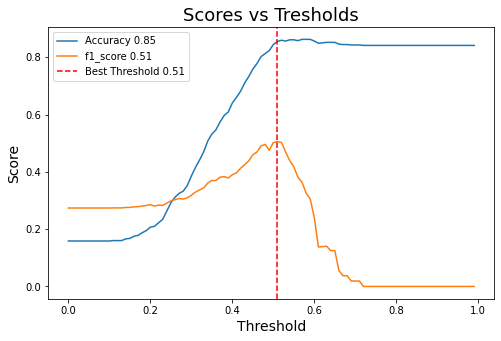

In [41]:
from sklearn.metrics import f1_score
y_pred_50 = lr2.predict(X_test)
y_proba = lr2.predict_proba(X_test)[:,1]
threshold = []
accuracy = []
roc_auc = []
f1score = []
for i in arange(0,1,0.01):
    predicted = (y_proba >= i).astype('int')
    threshold.append(i)
    accuracy.append(accuracy_score(y_test, predicted))
    roc_auc.append(roc_auc_score(y_test, y_proba))
    f1score.append(f1_score(y_test, predicted))
pd_df = pd.DataFrame({"Threshold": threshold,
                      'Accuracy': accuracy,
                      'ROC AUC': roc_auc,
                      'f1_score': f1score
                     }).sort_values("f1_score", ascending = False)

# Plot f1 and accuracy scores 
threshold = pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Threshold"].iloc[0]
accuracy= pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["Accuracy"].iloc[0]
AUC = pd_df[pd_df["f1_score"] == pd_df["f1_score"].max()]["ROC AUC"].iloc[0]
f1_score = pd_df["f1_score"].max()
pd_df = pd_df.sort_values("Threshold")
plt.figure(figsize=(8,5))
plt.plot(pd_df["Threshold"], pd_df["Accuracy"], label = "Accuracy %.2f"%(accuracy))
plt.plot(pd_df["Threshold"], pd_df["f1_score"], label = "f1_score %.2f"%(f1_score))
# plt.plot(pd_df["Threshold"], pd_df["ROC AUC"], label = "ROC AUC %.2f"%(AUC))
plt.axvline(threshold, color = "red", linestyle="dashed", label = "Best Threshold %.2f"%(threshold))
plt.xlabel('Threshold', fontsize = 14)
plt.ylabel('Score', fontsize = 14)
plt.title("Scores vs Tresholds", fontsize = 18, fontweight="bold")
plt.legend()
plt.show()

* ## Plot ROC Curve

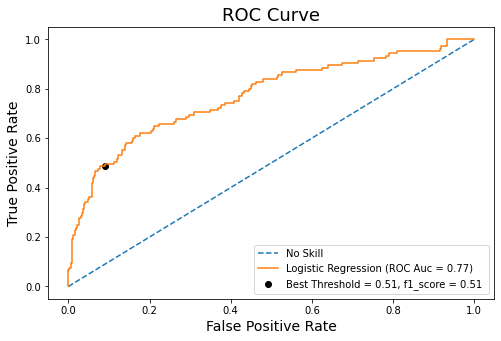

In [33]:
roc_curve_with_new_threshold(lr2, "Logistic Regression")

* ## Presicion Recall Curve

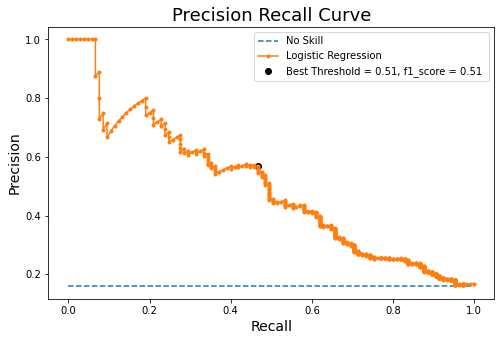

In [34]:
precision_recall_curve_with_new_threshold(lr2, "Logistic Regression")

* ## Siginificant Features

In [35]:
import statsmodels.api as sm
logit_model=sm.Logit(y, X)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.292271
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                 1470
Model:                          Logit   Df Residuals:                     1427
Method:                           MLE   Df Model:                           42
Date:                Thu, 29 Apr 2021   Pseudo R-squ.:                  0.3383
Time:                        12:33:27   Log-Likelihood:                -429.64
converged:                       True   LL-Null:                       -649.29
Covariance Type:            nonrobust   LLR p-value:                 1.246e-67
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Age                                  -0.0312      0.014     -2

* ## Feature Importance for Logistic Regression

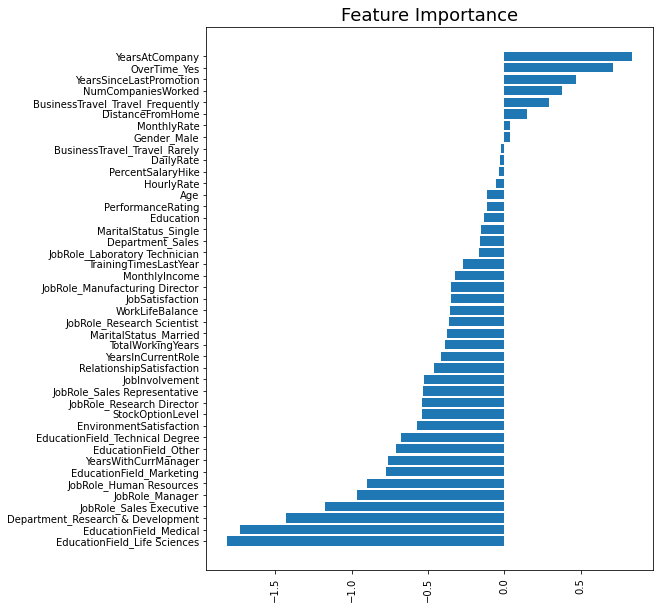

In [36]:
# Another Way
feature_importance=pd.DataFrame(np.hstack((np.array([list(X.columns)]).T, lr1.coef_.T)), columns=['feature', 'importance'])
feature_importance['importance']=pd.to_numeric(feature_importance['importance'])
feature_importance = feature_importance.sort_values(by='importance')
# plot feature importance
plt.figure(figsize=(8,10))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance", fontsize = 18)
plt.show()

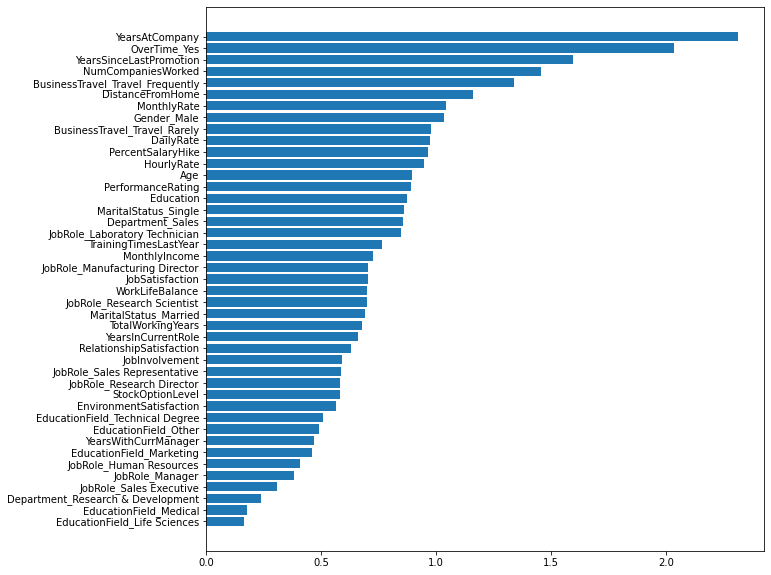

In [37]:
import math
feature_importance = pd.DataFrame(X.columns, columns = ["feature"])
feature_importance["importance"] = pow(math.e, lr1.coef_[0])
feature_importance = feature_importance.sort_values(by = ["importance"])
 
plt.figure(figsize = (10,10))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.show()

* ## Feature Importance for Random Forest

30


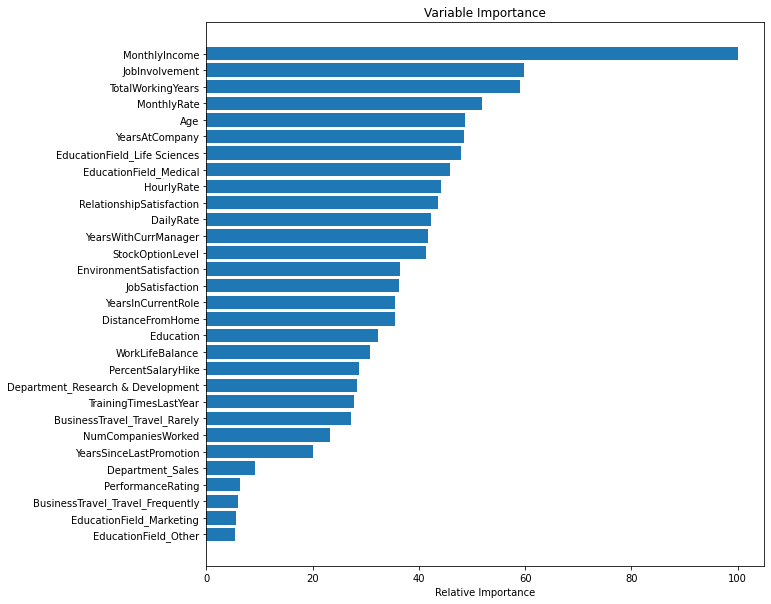

In [38]:
feature_importance = rf1.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()